# Regression of Little Kluane MB Data from EMY

In [1]:
import os 
import numpy as np 
import seaborn as sns 
import scipy.signal as signal
from scipy import linalg as LA
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

In [2]:
from scipy import optimize

def segments_fit(X, Y, count):
    """
    https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
    https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
    """
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)


In [3]:
MB  = np.load('../Data/surgio_withdeb_NMB.npy') # annual mass balance data from EMY
ZZ  = np.load('../Data/surgio_Zs.npy')          # Elevation used by EMY

x_c = np.loadtxt('../Data/SurfTopo.dat')[:,0]
z_s = np.loadtxt('../Data/SurfTopo.dat')[:,1]
z_b = np.loadtxt('../Data/BedTopo.dat')[:,1]

# Take temporal average of mb data
MB  = np.mean(MB,axis=0)                        # Annual mean mass balance

The regression won't be able to handel `nans` so lets remove all the `nan`s from the raster and flatten it to a column vector: 

Note we also remove an outlier which I have no idea why it's here...

In [4]:
# Get rid of nans and outlier
z   = ZZ[(~np.isnan(MB)) & ~(MB < -10)]
b   = MB[(~np.isnan(MB)) & ~(MB < -10)] # Can offset the MB here if needed

First things first we need to idenitfy the approximate location of the of ELA. Interpolation would be the sensible way to do this, but since our end goal is somekind of regression I'm going to hold off from doing this. 

Instead I will the find the 25 closest values to a zero mass balance and take the mean of their corresponding Elevations. For information on how to find the $N$ smallest elements (and their indexes) in an array see [here](https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/). 

In [5]:
z_ELA = np.mean(z[np.argpartition(np.abs(b),25)[:25]])

Lets take a look at our data and the approximate location of the ELA:

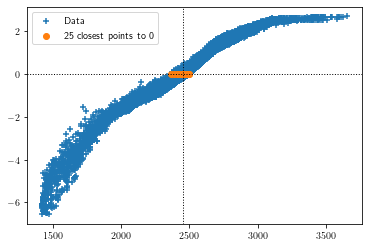

In [6]:
plt.scatter(z,b, marker="+",label='Data')
plt.scatter(z[np.argpartition(np.abs(b),25)[:25]],b[np.argpartition(np.abs(b),25)[:25]], marker="o", label='25 closest points to 0')

plt.axhline(0,ls=':', c='k', lw=1)
plt.axvline(z_ELA,ls=':', c='k', lw=1)

plt.legend()

Okay, that seems good enough for me! Lets transform our coordinate relative to Z_ela now:

In [7]:
z_R = z - z_ELA

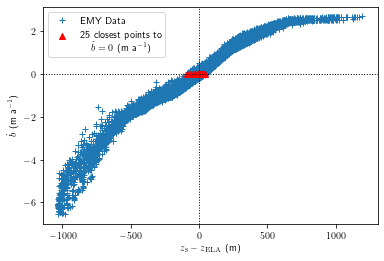

In [8]:
plt.plot(z_R,b,'+', label='EMY Data',zorder=0)

plt.scatter(z_R[np.argpartition(np.abs(b),25)[:25]],
            b[np.argpartition(np.abs(b),25)[:25]], 
            c='r', 
            marker="^", 
            label=r'\begin{center} 25 closest points to\\ $\dot b = 0$ (m a$^{-1}$) \end{center}',
           zorder=2)

plt.axhline(0,ls=':', c='k', lw=1)
plt.axvline(0,ls=':', c='k', lw=1)

plt.ylabel('$\dot b$ (m a$^{-1}$)');
plt.xlabel('$z_{\\rm s} - z_{\\rm ELA}$ (m)');

plt.legend()

plt.savefig('../plots/mb_v_transfromed_z.png',dpi=300, bbox_inches='tight',facecolor="w")

# Regression   

Lets fit some curves and look at the residuals. 

In [9]:
#return the indexes of the sorted arrays
idx = z_R.argsort()

#sort the arrays based on the elevation
z_R = z_R[idx]  
b   = b[idx]    

In [10]:
#Test various polynomial fits

poly_fits = [ ] 
for order in range(1,6):
    poly_fits.append( np.polyfit(z_R,b,order) )

In [11]:
# 3 piece-wise linear fit
px, py = segments_fit(z_R,b, 3)
# Calculate the slopes of regressions
ms = (  py[1:] - py[:-1]) / (px[1:] - px[:-1])
# Calculate the y-intercepts of regressions
bs = (-(py[1:] - py[:-1]) / (px[1:] - px[:-1]) * px[:-1] + py[:-1])

# Make the piecewise line with the regression data 
piese_wise = np.zeros_like(z_R)
piese_wise[z_R < px[1]]                   =  ms[0]* z_R[z_R < px[1]] + bs[0]
piese_wise[(px[1] < z_R) & (z_R < px[2])] =  ms[1]* z_R[(px[1] < z_R) & (z_R < px[2])] + bs[1]
piese_wise[px[2]< z_R]                    =  ms[2]* z_R[px[2]< z_R] + bs[2]


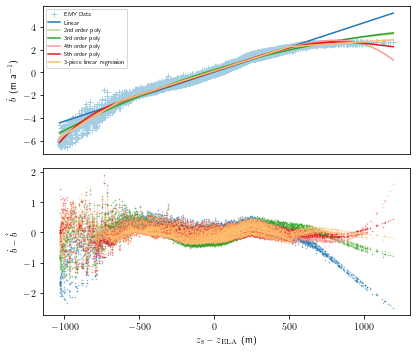

In [12]:
fig, ax = plt.subplots(2,1, figsize=(6,5))

labels = ['Linear', '2nd order poly.', '3rd order poly.', '4th order poly.', '5th order poly.', '3-piece linear regression']
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']

# Plot the raw data
ax[0].plot(z_R,b,'+', c=colors[0], label='EMY Data',zorder=0)

# Plot the polynomial fits
for order in range(0,5):
    ax[0].plot(z_R, np.polyval(poly_fits[order], z_R), label=labels[order], color=colors[order+1])

ax[0].plot(z_R, piese_wise,color=colors[-1], label=labels[-1])


ax[0].set_ylabel('$\dot b$ (m a$^{-1}$)');
ax[0].legend(fontsize='xx-small')

ax[0].get_xaxis().set_ticks([])

# Plot the residuals    
nbins = np.round(np.sqrt(z_R.shape[0])).astype(int)

for order in range(0,5):
    #sns.kdeplot(b  - np.polyval(poly_fits[order], z_R), axes=ax[1], color=colors[order+1],alpha=0.5)
    ax[1].plot(z_R, b - np.polyval(poly_fits[order], z_R), 'x', color=colors[order+1], markersize=1.0, alpha=0.5)

#sns.kdeplot(b - piese_wise, axes=ax[1], color=colors[-1],alpha=0.5)
ax[1].plot(z_R, b - piese_wise, 'x', color=colors[-1], markersize=1.0, alpha=0.5)

# for order in range(0,5):
#     sns.kdeplot( b  - np.polyval(poly_fits[order], z_R), axes=ax[2], color=colors[order+1],alpha=0.5)
    
# sns.kdeplot(b - piese_wise, axes=ax[2], color=colors[-1],alpha=0.5)   
# ax[2].set_xlim(-2.5,2.5)
# ax[2].set_xlabel('$\dot b - \hat{\dot{b}}$');   


ax[1].set_ylabel(r'$\dot b - \hat{\dot{b}}$');
ax[1].set_xlabel('$z_{\\rm s} - z_{\\rm ELA}$ (m)');   

fig.tight_layout()

fig.savefig('../plots/regression_test.png', dpi=300, bbox_inches='tight', facecolor='w')

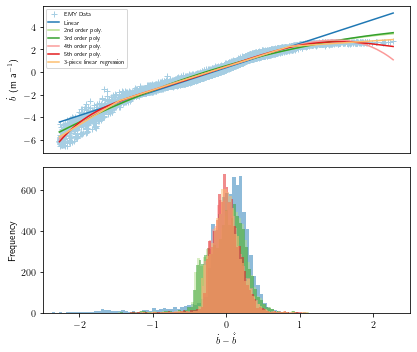

In [13]:
fig, ax = plt.subplots(2,1, figsize=(6,5))

labels = ['Linear', '2nd order poly.', '3rd order poly.', '4th order poly.', '5th order poly.', '3-piece linear regression']
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']

# Plot the raw data
ax[0].plot(z_R,b,'+', c=colors[0], label='EMY Data',zorder=0)

# Plot the polynomial fits
for order in range(0,5):
    ax[0].plot(z_R, np.polyval(poly_fits[order], z_R), label=labels[order], color=colors[order+1])

ax[0].plot(z_R, piese_wise,color=colors[-1], label=labels[-1])


ax[0].set_ylabel('$\dot b$ (m a$^{-1}$)');
ax[0].legend(fontsize='xx-small')

ax[0].get_xaxis().set_ticks([])

# Plot the residuals    
nbins = np.round(np.sqrt(z_R.shape[0])).astype(int)

for order in range(0,5):
    ax[1].hist(b - np.polyval(poly_fits[order],z_R), bins=nbins, color=colors[order+1],alpha=0.5)
    #sns.kdeplot( b  - np.polyval(poly_fits[order], z_R), axes=ax[1], color=colors[order+1],alpha=0.5)
    
ax[1].hist(b - piese_wise, bins=nbins, color=colors[-1],alpha=0.5)
#sns.kdeplot(b - piese_wise, axes=ax[1], color=colors[-1],alpha=0.5)   

ax[1].set_xlim(-2.5,2.5)
ax[1].set_xlabel('$\dot b - \hat{\dot{b}}$');   
ax[1].set_ylabel('Frequency');   

fig.tight_layout()

fig.savefig('../plots/regression_dist.png', dpi=300, bbox_inches='tight', facecolor='w')

In [23]:
def r_sqared(y, y_hat):
    ybar  = np.sum(y)/len(y)          
    ssreg = np.sum((y_hat-ybar)**2)  
    sstot = np.sum((y - ybar)**2)     
    return ssreg / sstot

In [15]:
for order in range(0,5):
    mu  = np.mean(b  - np.polyval(poly_fits[order], z_R))
    std = np.std(b  - np.polyval(poly_fits[order], z_R), ddof=1)
    r_2 = r_sqared(b, np.polyval(poly_fits[order], z_R))
    print('{}:'.format(labels[order]))
    print('\t mean: {:+2.3e}, std: {:2.3f}, R^2: {:2.3f}'.format(mu, std,r_2))

mu  = np.mean(b  - piese_wise)
std = np.std( b  - piese_wise, ddof=1)
r_2 = r_sqared(b, piese_wise)

print('{}:'.format(labels[-1]))
print('\t mean: {:+2.3e}, std: {:2.3f}, R^2: {:2.3f}'.format(mu, std,r_2))

Linear:
	 mean: -2.286e-16, std: 0.381, R^2: 0.957
2nd order poly.:
	 mean: +1.372e-15, std: 0.275, R^2: 0.977
3rd order poly.:
	 mean: -1.302e-15, std: 0.275, R^2: 0.978
4th order poly.:
	 mean: +3.840e-17, std: 0.225, R^2: 0.985
5th order poly.:
	 mean: -1.646e-17, std: 0.216, R^2: 0.986
3-piece linear regression:
	 mean: -3.759e-09, std: 0.219, R^2: 0.986


# Final Regression 

In [207]:
import time 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [208]:
# Get rid of nans and outlier
z   = ZZ[(~np.isnan(MB)) & ~(MB < -10)]
b   = MB[(~np.isnan(MB)) & ~(MB < -10)] # Can offset the MB here if needed

#return the indexes of the sorted arrays
idx = z.argsort()

#sort the arrays based on the elevation
z   = z[idx].reshape(-1,1)
b   = b[idx]    

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-download-auto-examples-miscellaneous-plot-kernel-ridge-regression-py

https://stackabuse.com/scikit-learn-save-and-restore-models/

In [214]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": np.geomspace(1e-1, 1e2, 4),
                               "gamma": np.geomspace(1e-6, 1e0, 7)})

z_train, z_test, b_train, b_test \
    = train_test_split(z, b, train_size=0.3, random_state=1)
    
#svr = SVR(kernel='rbf', gamma=0.00001, C = 0.5)

In [215]:
t0 = time.time()
svr.fit(z_train, b_train);
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

SVR complexity and bandwidth selected and model fitted in 44.367 s


In [216]:
sv_ratio = svr.best_estimator_.support_.shape[0] / z_train.shape[0]
print("Support vector ratio: %.3f" % sv_ratio)

Support vector ratio: 0.480


In [217]:
test = svr.predict(z)

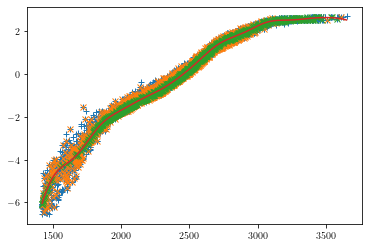

In [222]:
plt.plot(z, b, '+')
plt.plot(z_train[svr.best_estimator_.support_], b_train[svr.best_estimator_.support_], 'x')
plt.plot(z_train[np.setdiff1d(np.arange(len(z_train)), svr.best_estimator_.support_)], b_train[np.setdiff1d(np.arange(len(z_train)), svr.best_estimator_.support_)], 'x')
plt.plot(z, test)

In [204]:
svr.best_estimator_.score(z,b)

0.9886579206619713

# Some Archived Code 

We don't end up using this anymore, but very well could in the future. Therefore, to be extra safe let's just have a recored of it here. 


```python
MB     = np.load('../Data/surgio_withdeb_NMB.npy') # annual mass balance data from EMY
XX     = np.load('../Data/surgio_Xs.npy')          # UTM 7N Easting  coords
YY     = np.load('../Data/surgio_Ys.npy')          # UTM 7N Northing coords
ZZ     = np.load('../Data/surgio_Zs.npy')          # Elevation used by EMY

MB     = np.mean(MB,axis=0)                        # Annual mean mass balance
masked = np.ma.masked_array(MB, np.isnan(MB))      # Mask the no-data values


xres      = XX[0,1] - XX[0,0] 
yres      = YY[1,0] - YY[0,0] 
transform = Affine.translation(XX.min(), YY.max()) * Affine.scale(xres, -yres)

# Dictionary of projection related params for georefrencings
kwags = { 'driver'    :'GTiff', 
          'height'    : MB.shape[0], 
          'width'     : MB.shape[1], 
          'count'     : 1, 
          'dtype'     : MB.dtype, 
          'crs'       : '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs', 
          'transform' : transform
        }

# Write the data to temp file 
with MemoryFile() as memfile:
    kwags['dtype'] = 'float64'
    with memfile.open(**kwags) as src:
        src.write(MB.data,1)
        LK_CP['bdot'] = [x for x in src.sample(prof_coords)]
        LK_CP['bdot'] = LK_CP.apply(lambda x: x['bdot'][0], axis=1)
```


This code allows us to map project a `.npy` file in memory so that we can extract data along a flowline from a shape file. 